In [2]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, Model

from sklearn.utils.class_weight import compute_class_weight

from matplotlib import pyplot as plt

from datetime import datetime

import pickle

from PIL import Image

from custom_class import *

print(f"pd.__version__: {pd.__version__}")
print(f"tf.__version__: {tf.__version__}")

2025-02-27 23:25:19.680038: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-27 23:25:19.722531: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-27 23:25:19.722566: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-27 23:25:19.724179: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-27 23:25:19.735812: I tensorflow/core/platform/cpu_feature_guar

pd.__version__: 2.2.3
tf.__version__: 2.15.1


In [3]:
dataset_dir = "Dataset/machine-learning-in-science-ii-2025/test_data/test_data"

ds = tf.data.Dataset.list_files(
    os.path.join(dataset_dir, "*"), shuffle=False
)
image_count = len(ds)

for f in ds.take(5):
    print(f.numpy())

# Extract image IDs
def extract_image_id(file_path):
    file_path = file_path.numpy().decode("utf-8")  # Convert from bytes to string
    filename = os.path.basename(file_path)  # Extract "1.png", "10.png", etc.
    image_id = filename.split(".")[0]  # Extract "1", "10", "100"
    return image_id

image_id_list = []

for path in ds:
    image_id_list.append(extract_image_id(path))

image_id_list = np.array(image_id_list)

2025-02-27 23:25:21.522197: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-27 23:25:21.591181: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-27 23:25:21.591231: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-27 23:25:21.596139: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-27 23:25:21.596185: I external/local_xla/xla/stream_executor

b'Dataset/machine-learning-in-science-ii-2025/test_data/test_data/1.png'
b'Dataset/machine-learning-in-science-ii-2025/test_data/test_data/10.png'
b'Dataset/machine-learning-in-science-ii-2025/test_data/test_data/100.png'
b'Dataset/machine-learning-in-science-ii-2025/test_data/test_data/1000.png'
b'Dataset/machine-learning-in-science-ii-2025/test_data/test_data/1001.png'


In [4]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def process_path(file_path):
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img

In [5]:
ds = ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

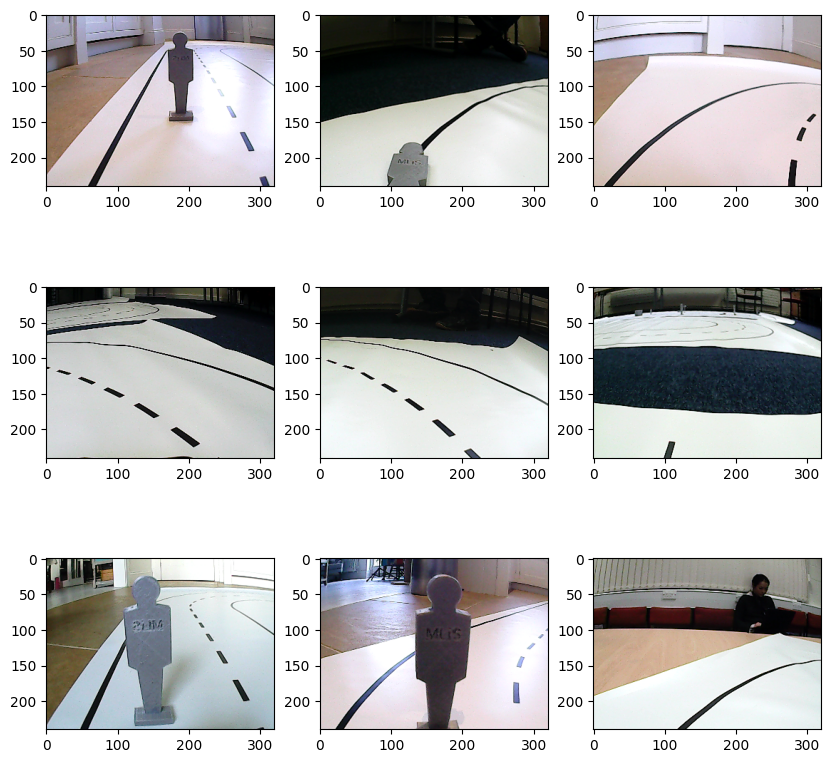

In [6]:
plt.figure(figsize=(10, 10))

i = 0

for image in ds.take(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("float32"))
    i += 1

In [7]:
def configure_for_performance(ds):
    ds = ds.batch(1, drop_remainder=False)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

ds = configure_for_performance(ds)

In [8]:
model = keras.models.load_model('Models/speed_model_epoch_45.keras'
                                , custom_objects={"WeightedBinaryCrossEntropy": WeightedBinaryCrossEntropy})

In [9]:
output = model.predict(ds)

2025-02-27 23:25:32.486993: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-02-27 23:25:32.627096: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


   9/1020 [..............................] - ETA: 7s   

2025-02-27 23:25:33.219312: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1020/1020 [==============================] - 10s 9ms/step


In [10]:
image_id_list

speed_pred = output['speed_output'][:, 0]

speed_pred = speed_pred > 0.5

speed_pred = np.array(speed_pred).astype(int)

print(speed_pred)
print(image_id_list)

[0 0 1 ... 1 0 1]
['1' '10' '100' ... '997' '998' '999']


In [11]:
df = pd.DataFrame({
  'image_id': image_id_list.astype(int), 
  'speed': speed_pred,
})

In [12]:
df = df.sort_values('image_id')
df

,image_id,speed
0,1,0
132,2,1
243,3,1
354,4,1
465,5,1
...,...,...
20,1016,1
21,1017,0
22,1018,1
23,1019,1


In [13]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")  # Format: YYYYMMDD_HHMM
df.to_csv(f'prediction_speed_{timestamp}.csv', index=False)

In [14]:
np.sum(speed_pred==1) / len(speed_pred)

0.5264705882352941